In [1]:
import glob, h5py, math, time, os, json, argparse, datetime

import torch
from torch import nn
import numpy as np
import sys
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from sklearn.model_selection import KFold

sys.path.append("..")
from data import get_database_path, get_h5_files, read_h5_file, select_events, classify_events
from utils import load_toml_config

import matplotlib.pyplot as plt

from classify import train_model
from analysis import Normalizer, train_test_split, get_dataloaders, calculate_auc, ClassifyDataset, predict

from metrics import BinaryACCUpdater
from model import MLP

import h5py

from visualize import plot_roc_curve

device = "cuda" if torch.cuda.is_available() else "mps" if sys.platform == "darwin" else "cpu"
random_seed = 114514
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [2]:
database_path = "/home/desmondhe/ADwithNE/latent"
output_dim = [2,4,8,16,32]
embedding_points_file_name = {}
embedding_points_file = {}
embedding_points = {}
targets = {}
for dim in output_dim:
    embedding_points_file_name[dim] = "embedding_points_dim{}.h5".format(dim)
    embedding_points_file[dim] = os.path.join(database_path, embedding_points_file_name[dim])
    embedding_points[dim] = h5py.File(embedding_points_file[dim])
bsm_events = ['charged_Higgs', 'leptoquark', 'neutral_Higgs', 'neutral_boson']
# Load bkg labels
bkg_id = np.load('../data/background_IDs_-1.npz')
set_labels = ['background_ID_train', 'background_ID_test', 'background_ID_val']
bkg_labels = np.concatenate([bkg_id[label] for label in set_labels], axis=0)

assert embedding_points[2]['SM'].shape[0] == len(bkg_labels)

# Binary

In [4]:
test_ratio=0.2
val_ratio = 0.2


# test_signal = "neutral_boson"
test_signal = "leptoquark"
# test_signal = "neutral_Higgs"
# test_signal = "charged_Higgs"
test_dimension = 2

normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
selected_idx = np.random.choice(embedding_points[test_dimension]['SM'].shape[0], len(np.array(embedding_points[test_dimension][test_signal])), replace=False)
exp_events, bkg_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx], np.array(embedding_points[test_dimension][test_signal])
X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
n1 = len(W1)
m1 = len(X1)
pi = n1 / (n1 + m1)
n2 = len(W2)
m2 = len(X2)
train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000)
test_dataset = ClassifyDataset(X2, W2, normalizer)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

In [5]:
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)

In [6]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.BCELoss()
acc_metric = BinaryACCUpdater()
metric_dict = {"Accuracy": acc_metric}

In [7]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-11-06 22:52:40
Epoch 1 / 50

100%|██████████| 109/109 [00:00<00:00, 224.49it/s, val_Accuracy=0.749, val_loss=0.517]
<<<<<< reach best val_Accuracy : 0.749493420124054 >>>>>>

================================================================================2024-11-06 22:52:43
Epoch 2 / 50

100%|██████████| 109/109 [00:00<00:00, 366.58it/s, val_Accuracy=0.765, val_loss=0.49]
<<<<<< reach best val_Accuracy : 0.7652618885040283 >>>>>>

================================================================================2024-11-06 22:52:45
Epoch 3 / 50

100%|██████████| 109/109 [00:00<00:00, 654.23it/s, val_Accuracy=0.767, val_loss=0.487]
<<<<<< reach best val_Accuracy : 0.7671451568603516 >>>>>>

================================================================================2024-11-06 22:52:47
Epoch 4 / 50

100%|██████████| 109/109 [00:00<00:00, 686.03it/s, val_Accuracy=0.769, val_loss=0.481]
<<<<<< reach best

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,0.572998,0.727192,0.517004,0.749493,1
1,0.499294,0.759566,0.489990,0.765262,2
2,0.490083,0.764829,0.486509,0.767145,3
3,0.485996,0.766543,0.481283,0.769040,4
4,0.481951,0.767139,0.478551,0.769318,5
5,0.479670,0.767442,0.477502,0.767773,6
6,0.478524,0.767355,0.475845,0.769614,7
7,0.477840,0.767739,0.475256,0.769513,8
8,0.477585,0.767765,0.475299,0.769186,9
9,0.477349,0.767814,0.475139,0.769662,10


In [9]:
targets, predictions = predict(naive_model, test_dataloader)

100%|██████████| 137/137 [00:00<00:00, 267.75it/s]


In [5]:
def calculate_accuracy(predictions, targets, threshold=0.5):

    binary_predictions = (predictions <= threshold).astype(int)
    
    correct_predictions = np.sum(binary_predictions == targets)
    total_samples = len(targets)

    accuracy = correct_predictions / total_samples
    return accuracy

In [11]:
print(calculate_accuracy(predictions, targets))

0.7688484634923431


# Multi-class

In [3]:
class MultiClassifyDataset(Dataset):
    def __init__(self, events, labels, normalizer):
        # Normalize the data
        if normalizer is not None:
            events = normalizer(events)


        self.events = torch.from_numpy(events).float()
        self.labels = torch.from_numpy(labels).to(torch.int64)

    
    def __len__(self):
        return len(self.events)
    
    def __getitem__(self, idx):
        return self.events[idx], self.labels[idx]

from sklearn.utils import shuffle

def sample_equal_class(events, labels, size=None):
    if size is None:
        sizes = []
        for label in np.unique(labels):
            sizes.append(np.sum(labels == label))
        size = np.min(sizes)
    
    indices = []
    for label in np.unique(labels):
        class_idx = np.where(labels == label)[0]
        indice = np.random.choice(class_idx, size=size, replace=False)
        indices.extend(indice)
    assert len(indices) == len(np.unique(labels)) * size

    events = events[indices]
    labels = labels[indices]

    events, labels = shuffle(events, labels, random_state=0)
    return events, labels
        


In [11]:
test_ratio=0.2
val_ratio = 0.2



test_dimension = 32
test_signal = "SM"
normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])

bkg = np.array(embedding_points[test_dimension][test_signal])
print(type(bkg))
print(type(bkg_labels))
selected_bkg, selected_labels = sample_equal_class(bkg, bkg_labels)
print(selected_bkg.shape)
print(selected_labels.shape)

size = len(selected_bkg)
test_size = int(size * test_ratio)
val_size = int((size-test_size) * val_ratio)
train_size = size - test_size - val_size

train_bkg, train_labels = selected_bkg[:train_size], selected_labels[:train_size]
val_bkg, val_labels = selected_bkg[train_size:train_size+val_size], selected_labels[train_size:train_size+val_size]
test_bkg, test_labels = selected_bkg[train_size+val_size:], selected_labels[train_size+val_size:]

train_dataset = MultiClassifyDataset(train_bkg, train_labels, normalizer)
val_dataset = MultiClassifyDataset(val_bkg, val_labels, normalizer)
test_dataset = MultiClassifyDataset(test_bkg, test_labels, normalizer)

train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=4)
val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False, pin_memory=True, num_workers=10, prefetch_factor=4)
test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(165416, 32)
(165416,)


In [12]:
class MLPmulti(nn.Module):
    def __init__(self, input_size, hidden_sizes, num_class):
        super(MLPmulti, self).__init__()
        def make_layer(in_size, out_size):
            layer = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.LeakyReLU(),
                # nn.Dropout(0.1)
            )
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='leaky_relu')
            return layer
        self.layers = nn.Sequential(
            make_layer(input_size, hidden_sizes[0]),
            *[make_layer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)],
            nn.Linear(hidden_sizes[-1], num_class),
        )
    

    def forward(self, x):
        return self.layers(x)

In [72]:
hidden_dim = [8, 16, 16, 16, 8]
naive_model = MLPmulti(test_dimension, hidden_dim, len(np.unique(bkg_labels)))

In [5]:

def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))
        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))

        return res[0]  


In [74]:
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
metric_dict = {"Accuracy": accuracy}

In [6]:
def printlog(info):
    now_time = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n" + "==========" * 8 + "%s" % now_time)
    print(str(info) + "\n")

class StepRunner:
    def __init__(self, net, loss_fn, 
                 stage="train", metrics_dict=None,
                 optimizer=None
                 ):
        self.model, self.loss_fn, self.metrics_dict, self.stage = net, loss_fn, metrics_dict, stage
        self.optimizer = optimizer

    def step(self, embedding_point, label):
        # forward
        embedding_point, label = embedding_point.to(device), label.to(device)
        predict = self.model(embedding_point)
        # loss
        loss = self.loss_fn(predict, label)

        # backward
        if self.optimizer is not None and self.stage == "train":
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()

        # metrics
        step_metrics = {self.stage + "_" + name: (metric_fn(predict, label)).item()
                        for name, metric_fn in self.metrics_dict.items()}
        return loss.item(), step_metrics

    def train_step(self, embedding_point, label):
        self.model.train()
        return self.step(embedding_point, label)

    @torch.no_grad()
    def eval_step(self, embedding_point, label):
        self.model.eval()
        return self.step(embedding_point, label)

    def __call__(self, embedding_point, label):
        if self.stage == "train":
            return self.train_step(embedding_point, label)
        else:
            return self.eval_step(embedding_point, label)


class EpochRunner:
    def __init__(self, step_runner, verbose=True):
        self.step_runner = step_runner
        self.stage = step_runner.stage
        self.verbose = verbose

    def __call__(self, dataloader):
        total_loss, step = 0, 0
        if self.verbose:
            loop = tqdm(enumerate(dataloader), total=len(dataloader), file=sys.stdout)
        else:
            loop = enumerate(dataloader)
        epoch_log = {}
        for batch_idx, (embedding_point, label) in loop:
            loss, step_metrics = self.step_runner(embedding_point, label)
            step_log = dict({self.stage + "_loss": loss}, **step_metrics)
            total_loss += loss
            step += 1
            if batch_idx != len(dataloader) - 1:
                if self.verbose:
                    loop.set_postfix(**step_log)
            else:
                epoch_loss = total_loss / step
                epoch_log = dict({self.stage + "_loss": epoch_loss}, **step_metrics) 
                if self.verbose:
                    loop.set_postfix(**epoch_log)

        return epoch_log


# @torch.compile()
def train_model(net, optimizer,
                loss_fn, 
                metrics_dict,
                train_dataloader, val_dataloader=None,
                scheduler=None,
                epochs=10, ckpt_path='checkpoint.pt',
                patience=5, monitor="train_MAPE", mode="min", verbose=True):
    history = {}

    for epoch in range(1, epochs + 1):
        if verbose:
            printlog("Epoch {0} / {1}".format(epoch, epochs))

        # 1，train -------------------------------------------------  
        train_step_runner = StepRunner(net=net, stage="train",
                                       loss_fn=loss_fn, metrics_dict=metrics_dict,
                                       optimizer=optimizer)
        train_epoch_runner = EpochRunner(train_step_runner, verbose=verbose)
        train_metrics = train_epoch_runner(train_dataloader)

        for name, metric in train_metrics.items():
            history[name] = history.get(name, []) + [metric]

        # 2，validate -------------------------------------------------
        if val_dataloader:
            val_step_runner = StepRunner(net=net, stage="val",
                                         loss_fn=loss_fn, metrics_dict=metrics_dict)
            val_epoch_runner = EpochRunner(val_step_runner, verbose=verbose)
            with torch.no_grad():
                val_metrics = val_epoch_runner(val_dataloader)
            val_metrics["epoch"] = epoch
            for name, metric in val_metrics.items():
                history[name] = history.get(name, []) + [metric]

            # 3，early-stopping -------------------------------------------------
        arr_scores = history[monitor]
        best_score_idx = np.argmax(arr_scores) if mode == "max" else np.argmin(arr_scores)
        if best_score_idx == len(arr_scores) - 1:
            torch.save(net.state_dict(), ckpt_path)
            if verbose:
                print("<<<<<< reach best {0} : {1} >>>>>>".format(monitor,
                                                                arr_scores[best_score_idx]))
        if len(arr_scores) - best_score_idx > patience:
            if verbose:
                print("<<<<<< {} without improvement in {} epoch, early stopping >>>>>>".format(
                    monitor, patience))
            break
        if scheduler:
            scheduler.step()
    net.load_state_dict(torch.load(ckpt_path))
    return pd.DataFrame(history)

In [76]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-11-08 19:10:25
Epoch 1 / 50

100%|██████████| 27/27 [00:00<00:00, 419.93it/s, val_Accuracy=57.9, val_loss=1.06]
<<<<<< reach best val_Accuracy : 57.93991470336914 >>>>>>

================================================================================2024-11-08 19:10:25
Epoch 2 / 50

100%|██████████| 27/27 [00:00<00:00, 404.68it/s, val_Accuracy=68.9, val_loss=0.795]
<<<<<< reach best val_Accuracy : 68.88412475585938 >>>>>>

================================================================================2024-11-08 19:10:26
Epoch 3 / 50

100%|██████████| 27/27 [00:00<00:00, 386.79it/s, val_Accuracy=71.2, val_loss=0.719]
<<<<<< reach best val_Accuracy : 71.24463653564453 >>>>>>

================================================================================2024-11-08 19:10:27
Epoch 4 / 50

100%|██████████| 27/27 [00:00<00:00, 386.85it/s, val_Accuracy=71.9, val_loss=0.691]
<<<<<< reach best val_Accuracy 

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,1.287211,56.055363,1.061401,57.939915,1
1,0.901054,71.395615,0.794843,68.884125,2
2,0.758288,73.010384,0.718565,71.244637,3
3,0.711508,76.124565,0.691238,71.888412,4
4,0.688877,73.587082,0.673785,72.532188,5
5,0.671925,76.816612,0.655552,73.819740,6
6,0.655599,73.933105,0.645946,74.892708,7
7,0.639495,76.355247,0.635120,76.609444,8
8,0.630574,77.623993,0.618004,74.892708,9
9,0.622836,78.316032,0.613065,74.892708,10


In [13]:
class Linear(nn.Module):
    def __init__(self, input_size):
        super(Linear, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x).reshape(-1)
    
class LinearMultiClass(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LinearMultiClass, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, num_classes),
        )
    
    def forward(self, x):
        return self.layers(x)
    
class MLP(nn.Module):
    def __init__(self, input_size, hidden_sizes):
        super(MLP, self).__init__()
        def make_layer(in_size, out_size):
            layer = nn.Sequential(
                nn.Linear(in_size, out_size),
                nn.LeakyReLU(),
                # nn.Dropout(0.1)
            )
            nn.init.kaiming_normal_(layer[0].weight, nonlinearity='leaky_relu')
            return layer
        self.layers = nn.Sequential(
            make_layer(input_size, hidden_sizes[0]),
            *[make_layer(hidden_sizes[i], hidden_sizes[i+1]) for i in range(len(hidden_sizes)-1)],
            nn.Linear(hidden_sizes[-1], 1),
            nn.Sigmoid()
        )
    

    def forward(self, x):
        return self.layers(x).reshape(-1)

In [17]:
naive_model = LinearMultiClass(test_dimension, len(np.unique(bkg_labels)))
naive_model.to(device)
optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.CrossEntropyLoss()
metric_dict = {"Accuracy": accuracy}


In [18]:
train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50
    )


================================================================================2024-11-08 19:36:22
Epoch 1 / 50

100%|██████████| 27/27 [00:00<00:00, 447.02it/s, val_Accuracy=52.1, val_loss=1.25]
<<<<<< reach best val_Accuracy : 52.14592361450195 >>>>>>

================================================================================2024-11-08 19:36:23
Epoch 2 / 50

100%|██████████| 27/27 [00:00<00:00, 436.49it/s, val_Accuracy=61.2, val_loss=1.15]
<<<<<< reach best val_Accuracy : 61.15879821777344 >>>>>>

================================================================================2024-11-08 19:36:23
Epoch 3 / 50

100%|██████████| 27/27 [00:00<00:00, 428.89it/s, val_Accuracy=62.7, val_loss=1.08]
<<<<<< reach best val_Accuracy : 62.660945892333984 >>>>>>

================================================================================2024-11-08 19:36:24
Epoch 4 / 50

100%|██████████| 27/27 [00:00<00:00, 452.61it/s, val_Accuracy=64.8, val_loss=1.03]
<<<<<< reach best val_Accuracy : 

,train_loss,train_Accuracy,val_loss,val_Accuracy,epoch
0,1.334899,57.670128,1.249895,52.145924,1
1,1.194364,61.937717,1.147568,61.158798,2
2,1.112977,68.627449,1.081740,62.660946,3
3,1.056258,69.319496,1.032587,64.806870,4
4,1.012495,68.166092,0.992903,66.738197,5
5,0.976799,67.243370,0.960107,67.596565,6
6,0.946857,70.934258,0.932633,67.596565,7
7,0.921225,72.895042,0.908884,67.381973,8
8,0.899047,70.357559,0.888007,67.811157,9
9,0.879621,69.434837,0.869177,68.454933,10


In [19]:
@torch.no_grad()
def predict_multi(model, dataloader, num_class):
    model.eval()
    batch_size = dataloader.batch_size
    targets = np.zeros(len(dataloader.dataset))
    predictions = np.zeros((len(dataloader.dataset), num_class))
    for i, (features, labels) in enumerate(tqdm(dataloader)):
        features = features.to(device)
        outputs = model(features)
        targets[i * batch_size: (i + 1) * batch_size] = labels.numpy()
        predictions[i * batch_size: (i + 1) * batch_size] = outputs.cpu().numpy()
    return targets, predictions

In [20]:
targets, predictions = predict_multi(naive_model, test_dataloader, 4)
print(type(predictions))
print(type(targets))
print(targets.shape)
print(predictions.shape)

100%|██████████| 34/34 [00:00<00:00, 441.03it/s]

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(33083,)
(33083, 4)


In [21]:
def top_k_accuracy(targets, predictions, k=1):
    """
    Computes the top-k accuracy for given targets and predictions.

    Args:
        targets (np.ndarray): True labels, shape (N,).
        predictions (np.ndarray): Predicted probabilities or scores, shape (N, C),
                                  where C is the number of classes.
        k (int): The "k" in top-k accuracy.

    Returns:
        float: The top-k accuracy as a percentage.
    """
    # 获取每个预测样本中，概率值最高的前k个类的索引
    top_k_preds = np.argsort(predictions, axis=1)[:, -k:]  # 取出每个样本的top-k预测类别
    
    # 判断每个目标值是否在对应样本的top-k预测类别中
    matches = np.any(top_k_preds == targets[:, None], axis=1)  # 在top-k内的为True，否则为False
    

    top_k_accuracy = np.mean(matches) * 100  # 转换为百分比

    return top_k_accuracy

In [22]:
print(top_k_accuracy(targets, predictions))

73.18864673699483


In [38]:
MLP_accuracy_array = np.zeros((len(output_dim)), dtype=float)
for i, test_dimension in enumerate(output_dim):
    test_signal = "SM"
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])

    bkg = np.array(embedding_points[test_dimension][test_signal])
    selected_bkg, selected_labels = sample_equal_class(bkg, bkg_labels)


    size = len(selected_bkg)
    test_size = int(size * test_ratio)
    val_size = int((size-test_size) * val_ratio)
    train_size = size - test_size - val_size

    train_bkg, train_labels = selected_bkg[:train_size], selected_labels[:train_size]
    val_bkg, val_labels = selected_bkg[train_size:train_size+val_size], selected_labels[train_size:train_size+val_size]
    test_bkg, test_labels = selected_bkg[train_size+val_size:], selected_labels[train_size+val_size:]

    train_dataset = MultiClassifyDataset(train_bkg, train_labels, normalizer)
    val_dataset = MultiClassifyDataset(val_bkg, val_labels, normalizer)
    test_dataset = MultiClassifyDataset(test_bkg, test_labels, normalizer)

    train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=4)
    val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False, pin_memory=True, num_workers=10, prefetch_factor=4)
    test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLPmulti(test_dimension, hidden_dim, len(np.unique(bkg_labels)))
    # naive_model = LinearMultiClass(test_dimension, len(np.unique(bkg_labels)))
    
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    metric_dict = {"Accuracy": accuracy}

    train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50,
    verbose=False
    )
    targets, predictions = predict_multi(naive_model, test_dataloader, 4)
    acc = top_k_accuracy(targets, predictions)
    print("Dim : ", test_dimension, "Accuracy : ", acc)
    MLP_accuracy_array[i] = acc


100%|██████████| 34/34 [00:00<00:00, 393.91it/s]


Dim :  2 Accuracy :  72.16092857358764


100%|██████████| 34/34 [00:00<00:00, 388.24it/s]


Dim :  4 Accuracy :  76.21134721760421


100%|██████████| 34/34 [00:00<00:00, 401.51it/s]


Dim :  8 Accuracy :  74.92972221382584


100%|██████████| 34/34 [00:00<00:00, 386.76it/s]


Dim :  16 Accuracy :  76.6284798839283


100%|██████████| 34/34 [00:00<00:00, 170.07it/s]

Dim :  32 Accuracy :  76.32923253634797


# K-fold

In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Set number of folds
k_folds = 5
val_ratio = 0.2
MLP_accuracy_array = np.zeros((len(output_dim)), dtype=float)
MLP_accuracy_variance_array = np.zeros((len(output_dim)), dtype=float)

for i, test_dimension in enumerate(output_dim):
    test_signal = "SM"
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
    bkg = np.array(embedding_points[test_dimension][test_signal])
    selected_bkg, selected_labels = sample_equal_class(bkg, bkg_labels)

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_index, test_index in kfold.split(selected_bkg):
        train_bkg, test_bkg = selected_bkg[train_index], selected_bkg[test_index]
        train_labels, test_labels = selected_labels[train_index], selected_labels[test_index]

        val_size = int(len(train_bkg) * val_ratio)
        val_bkg, val_labels = train_bkg[:val_size], train_labels[:val_size]
        train_bkg, train_labels = train_bkg[val_size:], train_labels[val_size:]

        # Create datasets and dataloaders
        train_dataset = MultiClassifyDataset(train_bkg, train_labels, normalizer)
        val_dataset = MultiClassifyDataset(val_bkg, val_labels, normalizer)
        test_dataset = MultiClassifyDataset(test_bkg, test_labels, normalizer)

        train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=4)
        val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False, pin_memory=True, num_workers=10, prefetch_factor=4)
        test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

        # Initialize model, optimizer, and loss function
        hidden_dim = [8, 16, 16, 16, 8]
        naive_model = MLPmulti(test_dimension, hidden_dim, len(np.unique(bkg_labels)))
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.CrossEntropyLoss()
        metric_dict = {"Accuracy": accuracy}

        # Train the model
        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
        )

        # Evaluate on the test set
        targets, predictions = predict_multi(naive_model, test_dataloader, 4)
        acc = top_k_accuracy(targets, predictions)
        fold_accuracies.append(acc)

    # Compute mean and variance for this dimension
    MLP_accuracy_array[i] = np.mean(fold_accuracies)
    MLP_accuracy_variance_array[i] = np.var(fold_accuracies)
    print(f"Dim : {test_dimension}, Mean Accuracy : {MLP_accuracy_array[i]}, Variance : {MLP_accuracy_variance_array[i]}")


100%|██████████| 34/34 [00:00<00:00, 169.31it/s]


Dim : 2, Mean Accuracy : 71.18416180744084, Variance : 7.871570034088171


100%|██████████| 34/34 [00:00<00:00, 401.66it/s]


Dim : 4, Mean Accuracy : 75.37059455429389, Variance : 1.3111098412469697


100%|██████████| 34/34 [00:00<00:00, 391.43it/s]


Dim : 8, Mean Accuracy : 75.54287324210334, Variance : 0.10937313410065483


100%|██████████| 34/34 [00:00<00:00, 388.21it/s]


Dim : 16, Mean Accuracy : 76.30821168462276, Variance : 0.36047513199270037


100%|██████████| 34/34 [00:00<00:00, 167.66it/s]

Dim : 32, Mean Accuracy : 77.0953307288407, Variance : 0.6347919483050101


In [44]:
single_accuracy_array = np.zeros((len(output_dim)), dtype=float)
for i, test_dimension in enumerate(output_dim):
    test_signal = "SM"
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])

    bkg = np.array(embedding_points[test_dimension][test_signal])
    selected_bkg, selected_labels = sample_equal_class(bkg, bkg_labels)


    size = len(selected_bkg)
    test_size = int(size * test_ratio)
    val_size = int((size-test_size) * val_ratio)
    train_size = size - test_size - val_size

    train_bkg, train_labels = selected_bkg[:train_size], selected_labels[:train_size]
    val_bkg, val_labels = selected_bkg[train_size:train_size+val_size], selected_labels[train_size:train_size+val_size]
    test_bkg, test_labels = selected_bkg[train_size+val_size:], selected_labels[train_size+val_size:]

    train_dataset = MultiClassifyDataset(train_bkg, train_labels, normalizer)
    val_dataset = MultiClassifyDataset(val_bkg, val_labels, normalizer)
    test_dataset = MultiClassifyDataset(test_bkg, test_labels, normalizer)

    train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=4)
    val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False, pin_memory=True, num_workers=10, prefetch_factor=4)
    test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    hidden_dim = [8, 16, 16, 16, 8]
    # naive_model = MLPmulti(test_dimension, hidden_dim, len(np.unique(bkg_labels)))
    naive_model = LinearMultiClass(test_dimension, len(np.unique(bkg_labels)))
    
    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.CrossEntropyLoss()
    metric_dict = {"Accuracy": accuracy}

    train_model(
    naive_model, optimizer,
    loss_fn, metrics_dict=metric_dict,
    train_dataloader=train_dataloader, val_dataloader=val_dataloader,
    monitor="val_Accuracy", mode="max",
    epochs=50,
    verbose=False
    )
    targets, predictions = predict_multi(naive_model, test_dataloader, 4)
    acc = top_k_accuracy(targets, predictions)
    print("Dim : ", test_dimension, "Accuracy : ", acc)
    single_accuracy_array[i] = acc
print(single_accuracy_array)

100%|██████████| 34/34 [00:00<00:00, 418.52it/s]


Dim :  2 Accuracy :  46.0357283196808


100%|██████████| 34/34 [00:00<00:00, 413.22it/s]


Dim :  4 Accuracy :  62.90239700148113


100%|██████████| 34/34 [00:00<00:00, 170.54it/s]


Dim :  8 Accuracy :  67.27322189644228


100%|██████████| 34/34 [00:00<00:00, 421.56it/s]


Dim :  16 Accuracy :  69.51606565305444


100%|██████████| 34/34 [00:00<00:00, 405.56it/s]

Dim :  32 Accuracy :  73.1765559350724
[46.03572832 62.902397   67.2732219  69.51606565 73.17655594]


In [45]:
from sklearn.model_selection import KFold
import numpy as np

# Set number of folds
k_folds = 5
val_ratio = 0.2
single_accuracy_array = np.zeros((len(output_dim)), dtype=float)
single_accuracy_variance_array = np.zeros((len(output_dim)), dtype=float)

for i, test_dimension in enumerate(output_dim):
    test_signal = "SM"
    normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
    bkg = np.array(embedding_points[test_dimension][test_signal])
    selected_bkg, selected_labels = sample_equal_class(bkg, bkg_labels)

    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    fold_accuracies = []

    for train_index, test_index in kfold.split(selected_bkg):
        train_bkg, test_bkg = selected_bkg[train_index], selected_bkg[test_index]
        train_labels, test_labels = selected_labels[train_index], selected_labels[test_index]

        val_size = int(len(train_bkg) * val_ratio)
        val_bkg, val_labels = train_bkg[:val_size], train_labels[:val_size]
        train_bkg, train_labels = train_bkg[val_size:], train_labels[val_size:]

        # Create datasets and dataloaders
        train_dataset = MultiClassifyDataset(train_bkg, train_labels, normalizer)
        val_dataset = MultiClassifyDataset(val_bkg, val_labels, normalizer)
        test_dataset = MultiClassifyDataset(test_bkg, test_labels, normalizer)

        train_dataloader = DataLoader(train_dataset, batch_size=1000, shuffle=True, pin_memory=True, num_workers=10, prefetch_factor=4)
        val_dataloader = DataLoader(val_dataset, batch_size=1000, shuffle=False, pin_memory=True, num_workers=10, prefetch_factor=4)
        test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

        # Initialize model, optimizer, and loss function
        
        naive_model = LinearMultiClass(test_dimension, len(np.unique(bkg_labels)))
        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.CrossEntropyLoss()
        metric_dict = {"Accuracy": accuracy}

        # Train the model
        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
        )

        # Evaluate on the test set
        targets, predictions = predict_multi(naive_model, test_dataloader, 4)
        acc = top_k_accuracy(targets, predictions)
        fold_accuracies.append(acc)

    # Compute mean and variance for this dimension
    single_accuracy_array[i] = np.mean(fold_accuracies)
    single_accuracy_variance_array[i] = np.var(fold_accuracies)
    print(f"Dim : {test_dimension}, Mean Accuracy : {single_accuracy_array[i]}, Variance : {single_accuracy_variance_array[i]}")

100%|██████████| 34/34 [00:00<00:00, 421.47it/s]


Dim : 2, Mean Accuracy : 45.47317589409121, Variance : 128.47332888025136


100%|██████████| 34/34 [00:00<00:00, 422.53it/s]


Dim : 4, Mean Accuracy : 59.99602140840864, Variance : 1.4505322967066214


100%|██████████| 34/34 [00:00<00:00, 418.30it/s]


Dim : 8, Mean Accuracy : 67.64036179754936, Variance : 10.52969583088577


100%|██████████| 34/34 [00:00<00:00, 399.34it/s]


Dim : 16, Mean Accuracy : 72.19374970665169, Variance : 0.4978270204612749


100%|██████████| 34/34 [00:00<00:00, 406.27it/s]

Dim : 32, Mean Accuracy : 71.46105166010011, Variance : 3.1976468026717675


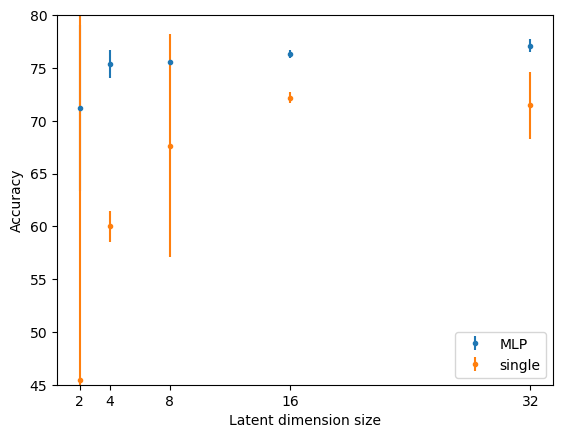

In [47]:
plt.errorbar(output_dim, MLP_accuracy_array, yerr=MLP_accuracy_variance_array, fmt='.', label='MLP')
plt.errorbar(output_dim, single_accuracy_array, yerr=single_accuracy_variance_array, fmt='.', label='single')
plt.xlabel('Latent dimension size')
plt.ylabel('Accuracy')
plt.ylim(45,80)
plt.legend()
plt.xticks(output_dim)
plt.show()

In [49]:
np.savez('../paper/single_layer_acc_bkg_classes_k_fold.npz', dimension=output_dim, mean_accuracy_5_fold=single_accuracy_array, standard_deviation_5_fold=single_accuracy_variance_array)
np.savez('../paper/MLP_acc_bkg_classes_k_fold.npz', dimension=output_dim, mean_accuracy_5_fold=MLP_accuracy_array, standard_deviation_5_fold=MLP_accuracy_variance_array)
npzfile = np.load('../paper/single_layer_acc_bkg_classes_k_fold.npz')
for key in npzfile.keys():
    print(key, ':', npzfile[key])
npzfile = np.load('../paper/MLP_acc_bkg_classes_k_fold.npz')
for key in npzfile.keys():
    print(key, ':', npzfile[key])


dimension : [ 2  4  8 16 32]
mean_accuracy_5_fold : [45.47317589 59.99602141 67.6403618  72.19374971 71.46105166]
standard_deviation_5_fold : [128.47332888   1.4505323   10.52969583   0.49782702   3.1976468 ]
dimension : [ 2  4  8 16 32]
mean_accuracy_5_fold : [71.18416181 75.37059455 75.54287324 76.30821168 77.09533073]
standard_deviation_5_fold : [7.87157003 1.31110984 0.10937313 0.36047513 0.63479195]


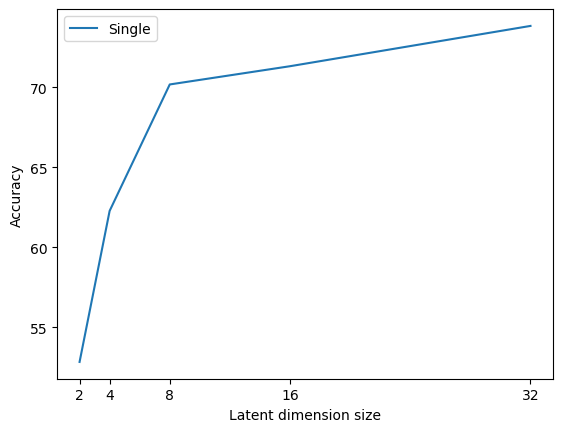

In [41]:
plt.plot(output_dim, single_accuracy_array, label='Single')
# plt.plot(output_dim, MLP_accuracy_array, label='MLP')
plt.xlabel('Latent dimension size')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(output_dim)
plt.show()

In [40]:
print(single_accuracy_array)
print(MLP_accuracy_array)

[52.8337817  62.2706526  70.17199166 71.31154974 73.82945924]
[72.16092857 76.21134722 74.92972221 76.62847988 76.32923254]


In [42]:
np.save('../paper/single_layer_acc_bkg_classes.npy', single_accuracy_array)
np.save('../paper/MLP_acc_bkg_classes.npy', MLP_accuracy_array)


In [ ]:
accuracy_array = np.zeros((len(output_dim), len(bsm_events)), dtype=float)
for i, test_dimension in enumerate(output_dim):
    for j, test_signal in enumerate(bsm_events):
        test_ratio=0.2
        val_ratio = 0.2

        normalizer = Normalizer(*[value for value in embedding_points[test_dimension].values()])
        selected_idx = np.random.choice(embedding_points[test_dimension]['SM'].shape[0], len(np.array(embedding_points[test_dimension][test_signal])), replace=False)
        exp_events, bkg_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx], np.array(embedding_points[test_dimension][test_signal])
        X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
        n1 = len(W1)
        m1 = len(X1)
        pi = n1 / (n1 + m1)
        n2 = len(W2)
        m2 = len(X2)
        train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer, train_batch_size=1000, val_batch_size=1000)
        test_dataset = ClassifyDataset(X2, W2, normalizer)
        test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

        # hidden_dim = [8, 16, 16, 16, 8]
        # naive_model = MLP(test_dimension, hidden_sizes=hidden_dim)

        naive_model = Linear(test_dimension)

        naive_model.to(device)
        optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
        loss_fn = nn.BCELoss()
        acc_metric = BinaryACCUpdater()
        metric_dict = {"Accuracy": acc_metric}
        train_model(
            naive_model, optimizer,
            loss_fn, metrics_dict=metric_dict,
            train_dataloader=train_dataloader, val_dataloader=val_dataloader,
            monitor="val_Accuracy", mode="max",
            epochs=50,
            verbose=False
            )
        
        targets, predictions = predict(naive_model, test_dataloader)
        accuracy = calculate_accuracy(predictions, targets)
        print("Dim : ", test_dimension, "Signal : ", test_signal, "Accuracy : ", accuracy)
        accuracy_array[i][j] = accuracy

100%|██████████| 305/305 [00:01<00:00, 298.64it/s]


Dim :  2 Signal :  charged_Higgs Accuracy :  0.7743382328762619


100%|██████████| 137/137 [00:00<00:00, 415.86it/s]


Dim :  2 Signal :  leptoquark Accuracy :  0.7490566591786695


100%|██████████| 277/277 [00:00<00:00, 306.15it/s]


Dim :  2 Signal :  neutral_Higgs Accuracy :  0.63044547473184


100%|██████████| 23/23 [00:00<00:00, 414.91it/s]


Dim :  2 Signal :  neutral_boson Accuracy :  0.5


100%|██████████| 305/305 [00:01<00:00, 293.46it/s]


Dim :  4 Signal :  charged_Higgs Accuracy :  0.8564039327874782


100%|██████████| 137/137 [00:00<00:00, 302.36it/s]


Dim :  4 Signal :  leptoquark Accuracy :  0.7605969842458412


100%|██████████| 277/277 [00:00<00:00, 288.97it/s]


Dim :  4 Signal :  neutral_Higgs Accuracy :  0.6677781233499931


100%|██████████| 23/23 [00:00<00:00, 136.44it/s]


Dim :  4 Signal :  neutral_boson Accuracy :  0.5


100%|██████████| 305/305 [00:01<00:00, 294.65it/s]


Dim :  8 Signal :  charged_Higgs Accuracy :  0.868577159580415


100%|██████████| 137/137 [00:00<00:00, 405.82it/s]


Dim :  8 Signal :  leptoquark Accuracy :  0.7778267189358234


100%|██████████| 277/277 [00:00<00:00, 286.32it/s]


Dim :  8 Signal :  neutral_Higgs Accuracy :  0.6750110301829202


100%|██████████| 23/23 [00:00<00:00, 402.89it/s]


Dim :  8 Signal :  neutral_boson Accuracy :  0.6927371806324817


100%|██████████| 305/305 [00:01<00:00, 286.90it/s]


Dim :  16 Signal :  charged_Higgs Accuracy :  0.8698891848344349


100%|██████████| 137/137 [00:00<00:00, 305.77it/s]


Dim :  16 Signal :  leptoquark Accuracy :  0.7891174440969623


100%|██████████| 277/277 [00:00<00:00, 289.53it/s]


Dim :  16 Signal :  neutral_Higgs Accuracy :  0.6792278148665167


100%|██████████| 23/23 [00:00<00:00, 403.38it/s]


Dim :  16 Signal :  neutral_boson Accuracy :  0.6954171877791674


100%|██████████| 305/305 [00:01<00:00, 296.82it/s]


Dim :  32 Signal :  charged_Higgs Accuracy :  0.8729637302291934


100%|██████████| 137/137 [00:00<00:00, 249.32it/s]


Dim :  32 Signal :  leptoquark Accuracy :  0.7927366427344403


100%|██████████| 277/277 [00:00<00:00, 283.04it/s]


Dim :  32 Signal :  neutral_Higgs Accuracy :  0.6879687827741091


100%|██████████| 23/23 [00:00<00:00, 135.01it/s]

Dim :  32 Signal :  neutral_boson Accuracy :  0.7370466321243523


[0.66346009 0.69619476 0.75353802 0.75841291 0.77267895]


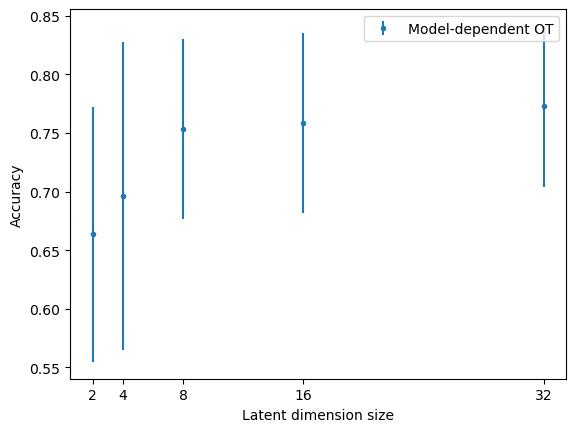

In [7]:
print(accuracy_array.mean(axis=1))
plt.errorbar(output_dim, accuracy_array.mean(axis=1), yerr=accuracy_array.std(axis=1), fmt='.', label='Model-dependent OT')
plt.xlabel('Latent dimension size')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(output_dim)
plt.show()

In [9]:
np.save('../paper/single_layer_acc.npy', accuracy_array)

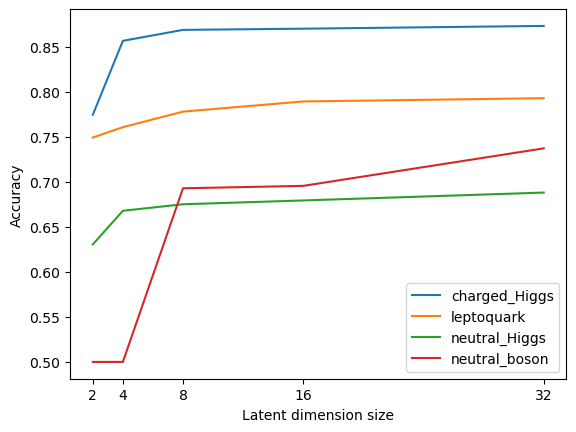

In [8]:
for signal in bsm_events:
    plt.plot(output_dim, accuracy_array[:, bsm_events.index(signal)], label=signal)
plt.xlabel('Latent dimension size')
plt.ylabel('Accuracy')
plt.legend()
plt.xticks(output_dim)
plt.show()

In [12]:
# Load raw events
files = load_toml_config("file")
database_path = get_database_path()

events = {}
for key, value in files.items():
    events[key] = read_h5_file(database_path, value)

Delphes = np.load(os.path.join('..', 'data', 'datasets_-1.npz'))
unpreprocessed_labels = ['x_train','x_test', 'x_val']
full_SM_dataset = np.concatenate([Delphes[label] for label in unpreprocessed_labels], axis=0)
events['SM'] = full_SM_dataset.reshape(full_SM_dataset.shape[:3])

In [14]:
for key in events.keys():
    events[key] = events[key][:, :, :3].reshape(events[key].shape[0], -1)
    print(key, events[key].shape)

SM (14451914, 57)
neutral_boson (55969, 57)
leptoquark (340544, 57)
neutral_Higgs (691283, 57)
charged_Higgs (760272, 57)


In [ ]:
bsm_events = ['charged_Higgs', 'leptoquark', 'neutral_Higgs', 'neutral_boson']
baseline_acc = np.zeros(len(bsm_events), dtype=float)

for i, test_signal in enumerate(bsm_events):
    test_ratio=0.2
    val_ratio = 0.2

    normalizer = Normalizer(*[value for value in events.values()])
    selected_idx = np.random.choice(embedding_points[test_dimension]['SM'].shape[0], len(np.array(embedding_points[test_dimension][test_signal])), replace=False)
    exp_events, bkg_events = np.array(embedding_points[test_dimension]['SM'])[selected_idx], np.array(embedding_points[test_dimension][test_signal])
    X1, X2, W1, W2 = train_test_split(exp_events, bkg_events, test_ratio)
    n1 = len(W1)
    m1 = len(X1)
    pi = n1 / (n1 + m1)
    n2 = len(W2)
    m2 = len(X2)
    train_dataloader, val_dataloader = get_dataloaders(X1, W1, val_ratio, normalizer=None, train_batch_size=1000, val_batch_size=1000)
    test_dataset = ClassifyDataset(X2, W2, None)
    test_dataloader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

    hidden_dim = [8, 16, 16, 16, 8]
    naive_model = MLP(57, hidden_sizes=hidden_dim)

    naive_model.to(device)
    optimizer = torch.optim.Adam(naive_model.parameters(), lr=1e-3, weight_decay=1e-5)
    loss_fn = nn.BCELoss()
    acc_metric = BinaryACCUpdater()
    metric_dict = {"Accuracy": acc_metric}
    train_model(
        naive_model, optimizer,
        loss_fn, metrics_dict=metric_dict,
        train_dataloader=train_dataloader, val_dataloader=val_dataloader,
        monitor="val_Accuracy", mode="max",
        epochs=50
        )
    
    targets, predictions = predict(naive_model, test_dataloader)
    accuracy = calculate_accuracy(predictions, targets)
    print("Dim : ", test_dimension, "Signal : ", test_signal, "Accuracy : ", accuracy)
    baseline_acc[i] = accuracy

NameError: name 'events' is not defined